# XANES Analysis
This example covers:
1. Read processed data
2. Read standards
3. Recalibrate data
4. XANES analysis
5. Save processed data

Reading is shown using processed data in previous notebook and data from the article. The data comes from Athena project files.

After reading the data is presented as a plot.

XANES is performed by plotting the standards and the data together to enable comparison.


## Resources
Pyhon modules and libraries used in this example

In [1]:
# code for importing custom helper libraries
import sys
# moved all custom helper libraries to a level bellow this directory.
sys.path.append('../lib/')

# Library with the functions that provide the larch functionalities
# equivalent to those provided by athena including normalisation, 
# merging, re-binning, LCF and visualisation (plotting)
import manage_athena as athenamgr 

# additional custom plot functions (replicate plots in published papers)
import custom_plots

# File handling
from pathlib import Path

# Handling json files
import json

# printing formated json data
import pprint

# to copy the mutable types like dictionaries, use copy/deepcopy 
import copy

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

# 1. Read data

The process is divided in two steps. The first step entails reading the metadata which indicates the location of the data and some additional parameters such as group names and file mappings. The second step uses this metadata to retrieve the process data from the files indicated in the metadata.

## Data mappings

Variables used for mapping processed data to results in paper. In this case these data are for figure 4A. The mappings are stored in a json file which was produced in the previous step named "PtSn_KEdge_processed.json".


In [2]:
json_file = "../outputs/PtSn_KEdge/PtSn_KEdge_processed.json"
json_metadata = {}

with open(json_file) as json_data:
    json_metadata = json.load(json_data)

pprint.pprint(json_metadata)

{'data_file': 'Xray_data.zip',
 'data_mapping': {'data_path': '../outputs/PtSn_KEdge',
                  'data_type': 'athena',
                  'file_mappings': [{'file_name': 'PtSn_KEdge_processed.prj',
                                     'group': 'PtSn',
                                     'group_name': 'PtSn'},
                                    {'file_name': 'PtSn_KEdge_processed.prj',
                                     'group': 'Air',
                                     'group_name': 'Air'},
                                    {'file_name': 'PtSn_KEdge_processed.prj',
                                     'group': 'Ar',
                                     'group_name': 'Ar'},
                                    {'file_name': 'PtSn_KEdge_processed.prj',
                                     'group': 'H2',
                                     'group_name': 'H2'},
                                    {'file_name': 'PtSn_KEdge_processed.prj',
                                    

## Read processed data

The process below reads the data from the output file generated in the previous step and collects the groups in a dictionary for further processing and analysis

In [3]:
snkedge_data={}

# read all samples, merge and then normalise
project_path = Path(json_metadata["data_mapping"]["data_path"])

for a_mapping in json_metadata["data_mapping"]["file_mappings"]:
    # project file name
    project_name = a_mapping['file_name']
    # name assigned to the readings for processing and display
    data_group =  a_mapping['group']    
    # the group names use underscores instead of spaces and periods 
    # in athena file
    group_name =  a_mapping['group_name']
    # read each group from the corresponding project file
    athena_project = athenamgr.read_project(Path(project_path,project_name))

    snkedge_data[data_group] = athenamgr.get_group(athena_project, group_name)

Just to check we plot the data collected so far 

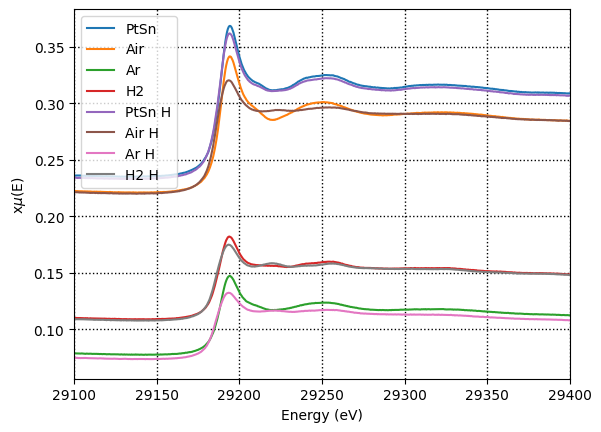

In [4]:
for a_group in snkedge_data:
   plt = athenamgr.plot_mu(snkedge_data[a_group])

plt.title("")
plt.xlim([29100, 29400])
plt.show()

# 2 Read standards
Next we read additional data which was provided with the publication in the form of athena data. We need to read the metadata first and then recover the actual data pointed by it
##  Read metadata for standards

In [5]:
standards_file = "./figure_4_standards.json"
standards_metadata = {}

with open(standards_file) as json_data:
    json_standards = json.load(json_data)

pprint.pprint(json_standards)

{'data_file': 'Xray_data.zip',
 'data_mapping': {'data_path': '../wf_data/pub_037/XAFS_prj/',
                  'file_mappings': [{'file_name': 'Sn foil.prj',
                                     'group': 'Sn Foil',
                                     'group_name': 'merge'},
                                    {'file_name': 'SnO2 0.9 2.6-13.5 gbkg.prj',
                                     'group': 'SnO2',
                                     'group_name': 'SnO2_0_9_2_6_13_5_0_8_1_0_with_theory'}],
                  'input_type': 'athena'},
 'data_object': {'cdi_do': 537, 'doi': '10.5258/SOTON/D0408'},
 'figure_id': 'Figure 1',
 'publication': {'cdi_pub': 37, 'doi': '10.1039/c7fd00221a'},
 'variables': {'reference_standard': 'Sn Foil'}}


## read standards
Read the data from the projects and plot the new set of groups

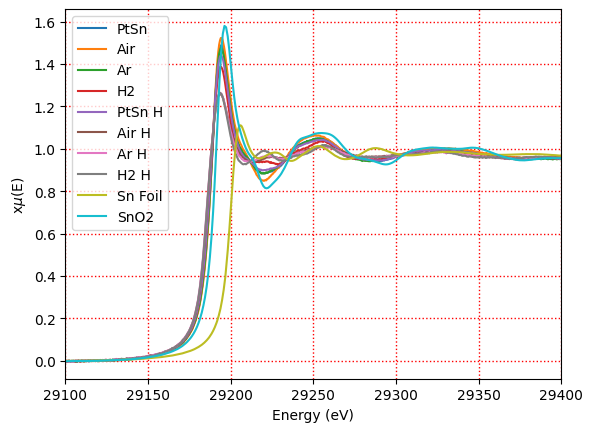

In [6]:
project_path = Path(json_standards["data_mapping"]["data_path"])

for a_mapping in json_standards["data_mapping"]["file_mappings"]:
    # project file name
    project_name = a_mapping['file_name']
    # name assigned to the readings for processing and display
    data_group =  a_mapping['group']    
    # the group names use underscores instead of spaces and periods 
    # in athena file
    group_name =  a_mapping['group_name']
    # read each group from the corresponding project file
    athena_project = athenamgr.read_project(Path(project_path,project_name))

    snkedge_data[data_group] = athenamgr.get_group(athena_project, group_name)
    snkedge_data[data_group].filename = data_group

for a_group in snkedge_data:
   plt = athenamgr.plot_normalised(snkedge_data[a_group])

plt.title("")
plt.xlim([29100, 29400])
plt.show()

# 3. Recalibrate data
The article indicates that the data is calibrated taking E0 from the standard (Sn Foil).
The code shows data before recalibration and then the results after recalibration (zooming on the E0 region)

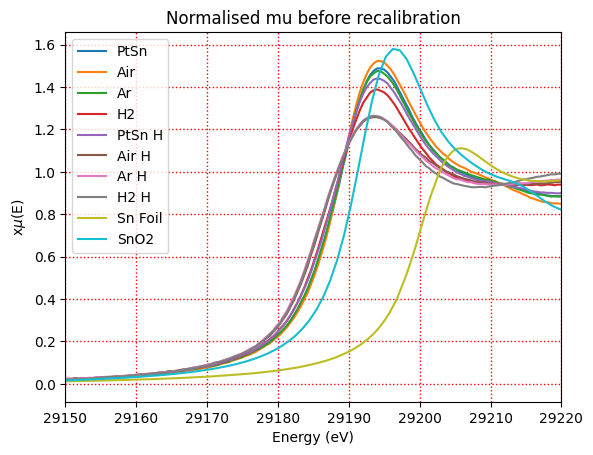

Will recalibrate all signals to : 29200.142 Sn Foil


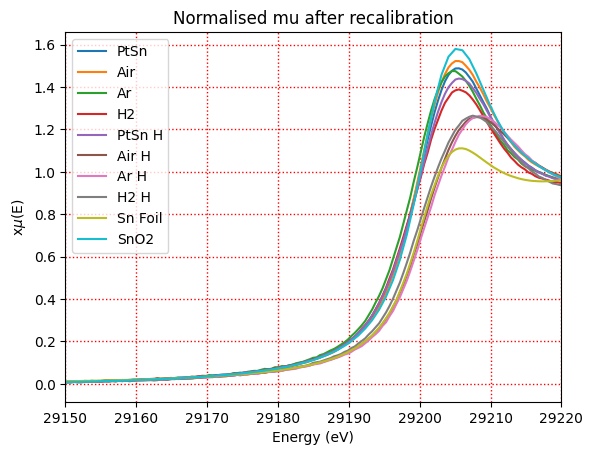

In [7]:
# plot data
for a_group in snkedge_data:
   plt = athenamgr.plot_normalised(snkedge_data[a_group])

plt.title("Normalised mu before recalibration")
plt.xlim([29150, 29220])
plt.show()


# get E0 from reference standard
reference_group = json_standards["variables"]["reference_standard"]
standard_e0 = athenamgr.get_group_e0(snkedge_data[reference_group])

print("Will recalibrate all signals to :", standard_e0, reference_group)

# recalibrate the standard E0
for a_sample in snkedge_data:
    snkedge_data[a_sample] = athenamgr.recalibrate_energy(snkedge_data[a_sample], standard_e0)

# plot data after recalibration
for a_group in snkedge_data:
   plt = athenamgr.plot_normalised(snkedge_data[a_group])

plt.title("Normalised mu after recalibration")
plt.xlim([29150, 29220])
plt.show()

# 4. XANES analysis

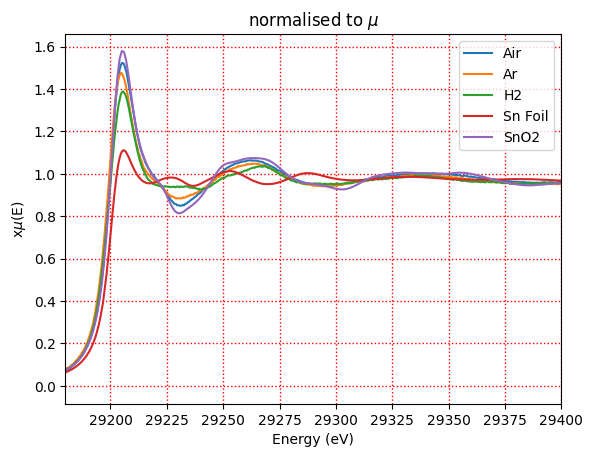

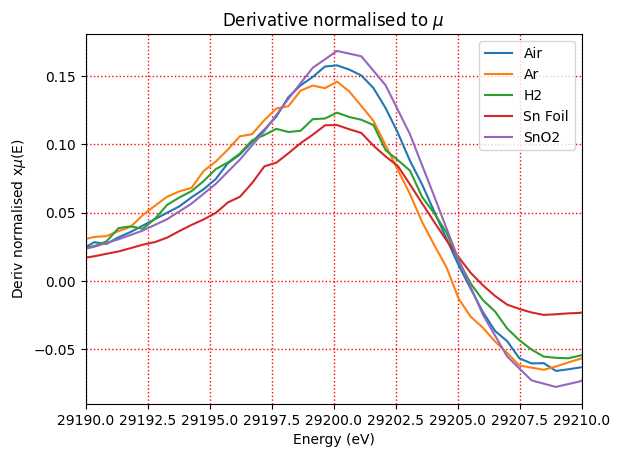

In [8]:
plot_these=["Air","Ar","H2", 'Sn Foil','SnO2']
for a_sample in snkedge_data:
    if a_sample in plot_these:
        plt = athenamgr.plot_normalised(snkedge_data[a_sample])
    
plt.xlim([29180, 29400])
plt.show()

for a_sample in snkedge_data:
    if a_sample in plot_these:
        plt = athenamgr.plot_derivative(snkedge_data[a_sample])
    
plt.xlim([29190, 29210])
plt.show()

# 4 Save data
The saving process is also divided in two steps, first the data is saved into an athena project, and then the corresponding  metadata is saved in a json file.

## Save Athena project
Store processed data in an Athena project file

In [9]:
# define the location of the output files
out_prefix = "PtSn_KEdge"
out_location = "../outputs"
# create a new output dir if it does not exist
out_dir = athenamgr.set_out_dir(out_prefix,out_location)
out_file = out_prefix+"_XANES.prj"
# save the data to that output dir
athenamgr.save_groups(snkedge_data.values(), Path(out_dir, out_file))


## Save mappings
Store the metadata required to support further processing.

In [10]:
# define the location of the output files
# save a json file with the results
# using the structure of the initial data mappings
out_mappings = copy.deepcopy(json_metadata)
file_mappings = []
for a_sample in snkedge_data:
    file_mappings.append ({'group':a_sample, 
                           'group_name':a_sample.replace(" ","_"),
                           'file_name': out_file.replace("\\","/")})

out_mappings['data_mapping']['data_path'] = str(out_dir).replace("\\","/")
out_mappings['data_mapping']['data_type'] = "athena"
out_mappings['data_mapping']['file_mappings'] = file_mappings

json_data = json.dumps(out_mappings, indent=4)
out_file_name = Path(out_dir, out_prefix+'_XANES.json')
with open(out_file_name, 'w', encoding='utf-8') as f:
    f.write(json_data)
print("Mapping data saved to:", str(out_file_name))

Mapping data saved to: ..\outputs\PtSn_KEdge\PtSn_KEdge_XANES.json


## References

The data used in this example is part of the supporting data for:

Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study. Faraday Discussions. V. 208. pp. 555-573. DOI:[10.1039/c7fd00221a](http://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository DOI: [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.